<a href="https://colab.research.google.com/github/victoria2012/TeamProject/blob/master/deeplearning/naver_finance_news_deeplearnig_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install xlrd opnepyxl

ERROR: Could not find a version that satisfies the requirement opnepyxl (from versions: none)
ERROR: No matching distribution found for opnepyxl


In [68]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ hash mecab
+ echo 'mecab-ko is already installed'
mecab-ko is already installed
+ [[ -d /usr/local/lib/mecab/dic/mecab-ko-dic ]]
+ echo 'mecab-ko-dic is already installed'
mecab-ko-dic is already installed
++ python3 -c 'import pkgutil; print(1 if pkgutil.find_loader("MeCab") else 0)'
+ [[ 1 == \1 ]]
+ echo 'mecab-python is already installed'
mecab-python is already installed
+ echo Done.
Done.


In [69]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [70]:
data = pd.read_excel('./naver_news_data_addscore_test_2.xls')
data

,id,date,time,posi_nega,title,content,press,stock,label
0,7968,2019-02-27,10:19,0,"바이로메드, 美 임상 결과 발표 지연 소식에 하락세",[머니투데이 진경진 기자] 바이로메드가 주력 파이프라인인 VM202-DPN(당뇨병성...,머니투데이,stock,-1
1,7969,2019-02-27,10:07,0,"아이엠텍, 상장폐지 위기감에 급락",[아시아경제 조호윤 기자]아이엠텍이 장 초반 급락했다.27일 오전 10시 아이엠텍은...,아시아경제,이엠텍,-1
2,7970,2019-02-27,10:02,0,"한솔홀딩스, 액면가 감자 결정...5%↓",[아시아경제 이정민 기자] 한솔홀딩스가 27일 장 초반 5%대 하락세를 걷고 있다....,아시아경제,한솔홀딩스,0
3,7980,2019-02-27,09:30,0,"바이로메드, 임상결과 지연에 약세",【서울=뉴시스】하종민 기자 = 코스닥 상장사 바이로메드(084990)가 임상결과 지...,뉴시스,stock,-1
4,7981,2019-02-27,09:30,0,"심텍, 자사주 소각 연기에 약세",【서울=뉴시스】김정호 기자 = 코스닥 전자부품 제조사 심텍(222800)이 자사주 ...,뉴시스,심텍,-1
...,...,...,...,...,...,...,...,...,...
10789,1121,2020-07-22,09:13,1,"티에스아이, 코스닥 상장 첫날 장중 급등",티에스아이 CI[IR큐더스 제공](서울=연합뉴스) 곽민서 기자 = 2차전지 생산장비...,연합뉴스,티에스아이,1
10790,1122,2020-07-22,09:13,1,"에스폴리텍, 美향 코로나19 가림막 수주 증가에 ‘강세’","[이데일리 유준하 기자] 광학용 시트 및 필름, 엔지니어링 플라스틱(EP) 전문 제...",이데일리,에스폴리텍,1
10791,1123,2020-07-22,09:09,1,"티에스아이, 상장 첫 날 '강세'",[이데일리 권효중 기자] 2차전지 믹싱 시스템 기업 티에스아이(277880)가 상장...,이데일리,티에스아이,1
10792,1124,2020-07-22,09:08,1,"SK케미칼, 자회사 아스트라제네카 CMO 계약 체결에↑",SK케미칼우는 상한가 기록 중[이데일리 이슬기 기자] SK케미칼(285130)이 자...,이데일리,아스트,1


In [71]:
from sklearn.model_selection import train_test_split

In [72]:
train_data, test_data = train_test_split(data)
train_data.shape, test_data.shape

((8095, 9), (2699, 9))

In [73]:
train_data[:10]

,id,date,time,posi_nega,title,content,press,stock,label
3896,6049,2019-04-24,09:14,1,"LG이노텍, 실적개선 기대에 강세",【서울=뉴시스】하종민 기자 = LG이노텍(011070) 주가가 실적개선 기대에 강세...,뉴시스,LG이노텍,1
1406,6447,2019-08-29,15:16,0,"삼성바이오, 이재용 부회장 뇌물혐의 추가 소식에 '급락'",[아시아경제 고형광 기자] 이재용 삼성전자 부회장에 대한 '국정농단 사건' 대법원 ...,아시아경제,stock,-1
5091,4515,2019-06-18,07:56,1,"""오스템임플란트, 턴어라운드 가속화 전망""",자료 제공 = 하이투자증권하이투자증권은 18일 오스템임플란트에 대해 턴어라운드가 가...,매일경제,오스템임플란트,0
7221,5464,2019-10-16,09:19,1,임상 성공 소식에 134% 오른 美바이오주…주주사 원풍물산도 급등,미국 나스닥시장에 상장한 바이오회사 렐마다 테러퓨틱스(RELMADA THERAPEU...,조선비즈,원풍물산,1
865,4369,2019-06-21,09:22,0,'백기사 델타항공 지분 매입'에 한진칼 약세,대한항공-델타항공 조인트벤처 출범 1주년 광고[대한항공 제공] (서울=연합뉴스...,연합뉴스,한진칼,-1
5173,4363,2019-06-21,09:29,1,"바른테크놀로지, 유상증자·CB발행에 상한가 기록",[아시아경제 금보령 기자] 바른테크놀로지가 21일 장 초반 상한가를 나타냈다. 대규...,아시아경제,stock,1
4413,5282,2019-05-21,14:18,1,"알파홀딩스, 자회사 임상 데이터 발표 임박에 강세",[이데일리 박태진 기자] 알파홀딩스(117670)가 자회사의 유방암 관련 임상 데이...,이데일리,알파홀딩스,1
853,4457,2019-06-19,09:13,0,"코스닥 상장 후 급등한 줌인터넷, 8%대 하락세",[머니투데이 진경진 기자] 코스닥 시장 상장 후 급등세를 보여왔던 줌인터넷이 8%대...,머니투데이,줌인터넷,0
4824,4826,2019-06-05,08:16,1,"""한국항공우주, 주가 발목잡은 악재 해소…실적 정상화 기대""",NH투자증권은 5일 한국항공우주에 대해 2분기 내 이라크 수출물량과 기자재 업체들의...,매일경제,한국항공우주,1
6246,6735,2019-08-19,14:47,1,"알에스오토, 로봇핵심 부품 국산화…탈일본 추진 대기업 구매 확약",[아시아경제 박형수 기자] 알에스오토메이션이 강세다. 로봇 및 스마트머신용 다축 서...,아시아경제,stock,1


In [74]:
train_data['posi_nega'].value_counts()

1    6379
0    1716
Name: posi_nega, dtype: int64

In [75]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8095 entries, 3896 to 8078
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         8095 non-null   int64 
 1   date       8095 non-null   object
 2   time       8095 non-null   object
 3   posi_nega  8095 non-null   int64 
 4   title      8095 non-null   object
 5   content    8095 non-null   object
 6   press      8095 non-null   object
 7   stock      8095 non-null   object
 8   label      8095 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 632.4+ KB


In [76]:
print(train_data['title'].nunique())
print(train_data['posi_nega'].nunique())

8095
2


In [77]:
print(train_data.isnull().sum())

id           0
date         0
time         0
posi_nega    0
title        0
content      0
press        0
stock        0
label        0
dtype: int64


In [78]:
train_data['title'] = train_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣↑↓ ]", "")
train_data[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,date,time,posi_nega,title,content,press,stock,label
3896,6049,2019-04-24,09:14,1,이노텍 실적개선 기대에 강세,【서울=뉴시스】하종민 기자 = LG이노텍(011070) 주가가 실적개선 기대에 강세...,뉴시스,LG이노텍,1
1406,6447,2019-08-29,15:16,0,삼성바이오 이재용 부회장 뇌물혐의 추가 소식에 급락,[아시아경제 고형광 기자] 이재용 삼성전자 부회장에 대한 '국정농단 사건' 대법원 ...,아시아경제,stock,-1
5091,4515,2019-06-18,07:56,1,오스템임플란트 턴어라운드 가속화 전망,자료 제공 = 하이투자증권하이투자증권은 18일 오스템임플란트에 대해 턴어라운드가 가...,매일경제,오스템임플란트,0
7221,5464,2019-10-16,09:19,1,임상 성공 소식에 오른 바이오주주주사 원풍물산도 급등,미국 나스닥시장에 상장한 바이오회사 렐마다 테러퓨틱스(RELMADA THERAPEU...,조선비즈,원풍물산,1
865,4369,2019-06-21,09:22,0,백기사 델타항공 지분 매입에 한진칼 약세,대한항공-델타항공 조인트벤처 출범 1주년 광고[대한항공 제공] (서울=연합뉴스...,연합뉴스,한진칼,-1
5173,4363,2019-06-21,09:29,1,바른테크놀로지 유상증자발행에 상한가 기록,[아시아경제 금보령 기자] 바른테크놀로지가 21일 장 초반 상한가를 나타냈다. 대규...,아시아경제,stock,1
4413,5282,2019-05-21,14:18,1,알파홀딩스 자회사 임상 데이터 발표 임박에 강세,[이데일리 박태진 기자] 알파홀딩스(117670)가 자회사의 유방암 관련 임상 데이...,이데일리,알파홀딩스,1
853,4457,2019-06-19,09:13,0,코스닥 상장 후 급등한 줌인터넷 대 하락세,[머니투데이 진경진 기자] 코스닥 시장 상장 후 급등세를 보여왔던 줌인터넷이 8%대...,머니투데이,줌인터넷,0
4824,4826,2019-06-05,08:16,1,한국항공우주 주가 발목잡은 악재 해소실적 정상화 기대,NH투자증권은 5일 한국항공우주에 대해 2분기 내 이라크 수출물량과 기자재 업체들의...,매일경제,한국항공우주,1
6246,6735,2019-08-19,14:47,1,알에스오토 로봇핵심 부품 국산화탈일본 추진 대기업 구매 확약,[아시아경제 박형수 기자] 알에스오토메이션이 강세다. 로봇 및 스마트머신용 다축 서...,아시아경제,stock,1


In [79]:
test_data['title'] = test_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣上下↑↓ ]", "")
test_data.head(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,date,time,posi_nega,title,content,press,stock,label
1902,3941,2020-01-28,09:23,0,신종코로나 공포에 중국 소비주 줄줄이 급락,붐비는 인천공항 입국 검역대(영종도=연합뉴스) 도광환 기자 = 국내에서 신종 코로나...,연합뉴스,stock,-1
7502,5069,2019-11-01,10:22,1,아이오케이 비덴트 투자 소식에 강세빗썸 지분 부각,[아시아경제 유현석 기자] 아이오케이가 강세다. 암호화폐 거래소인 빗썸의 최대주주 ...,아시아경제,아이오케이,1
507,5739,2019-05-07,09:23,0,코오롱티슈진생명과학 인보사 성분 변경 인지 의혹에 급락,【서울=뉴시스】류병화 기자 = 코오롱티슈진과 코오롱생명과학이 골관절염 치료제 '인보...,뉴시스,코오롱티슈진,-1
2644,7557,2019-03-12,09:29,1,롯데칠성 호실적 전망에 대 강세,롯데칠성이 올해 음료부문 사상 최대 이익이 기대된다는 전망에 강세를 나타내고 있다....,파이낸셜뉴스,롯데칠성,1


In [80]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [81]:
mecab = Mecab()

X_train = []
for sentence in train_data['title']:
  X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [82]:
print(X_train[:3])

[['이노', '텍', '실적', '개선', '기대', '강세'], ['삼성', '바이오', '이재용', '부회장', '뇌물', '혐의', '추가', '소식', '급락'], ['오', '스템', '임', '플란트', '턴', '어', '라운드', '가속', '화', '전망']]


In [83]:
X_test = []
for sentence in test_data['title']:
  X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [84]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'강세': 1, '소식': 2, '실적': 3, '급등': 4, '↑': 5, '기대': 6, '분기': 7, '주': 8, '약세': 9, '로': 10, '코로나': 11, '기대감': 12, '전망': 13, '상장': 14, '목표': 15, '적': 16, '급락': 17, '성장': 18, '바이오': 19, '대': 20, '억': 21, '규모': 22, '성': 23, '종합': 24, '상승': 25, '관련': 26, '개선': 27, '수혜': 28, '텍': 29, '↓': 30, '등': 31, '첫날': 32, '상한가': 33, '원': 34, '상승세': 35, '화': 36, '삼성': 37, '째': 38, '신고': 39, '삼성전자': 40, '투자': 41, '주가': 42, '개발': 43, '부각': 44, '사업': 45, '만': 46, '임상': 47, '부진': 48, '이틀': 49, '젠': 50, '씨': 51, '시장': 52, '인수': 53, '계약': 54, '기술': 55, '치료제': 56, '티': 57, '매각': 58, '확대': 59, '한진': 60, '인': 61, '어': 62, '자회사': 63, '코스닥': 64, '앤': 65, '소재': 66, '한국': 67, '진단': 68, '지분': 69, '에스': 70, '호실': 71, '제약': 72, '하락': 73, '증자': 74, '상': 75, '공급': 76, '셀': 77, '증가': 78, '사': 79, '수출': 80, '우려': 81, '이익': 82, '대주주': 83, '아': 84, '최대': 85, '칼': 86, '코오롱': 87, '중국': 88, '지속': 89, '반도체': 90, '결정': 91, '연속': 92, '세계': 93, '차': 94, '그룹': 95, '동반': 96, '조': 97, '생명': 98, '나': 99, '공모': 100, '신': 101, '최': 102, '매

In [85]:
threshold = 2
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print('전체 단어 수:', words_cnt)
print('빈도가 {} 이하인 희귀 단어수  : {}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율: {}'.format((rare_cnt / words_cnt)*100))
print('희귀 단어 등장 빈도비율: {}'.format((rare_freq / words_freq)*100))

전체 단어 수: 6049
빈도가 1 이하인 희귀 단어수  : 2169
희귀 단어 비율: 35.85716647379732
희귀 단어 등장 빈도비율: 3.072934376062564


In [86]:
vocab_size = words_cnt-rare_cnt+2
print(vocab_size)

3882


In [87]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [88]:
y_train = np.array(train_data['posi_nega'])
y_test = np.array(test_data['posi_nega'])
y_train

array([1, 0, 1, ..., 1, 1, 1])

In [89]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이: ', sum(map(len, X_train))/len(X_train))

리뷰 최대 길이: 19
리뷰 평균 길이:  8.719456454601605


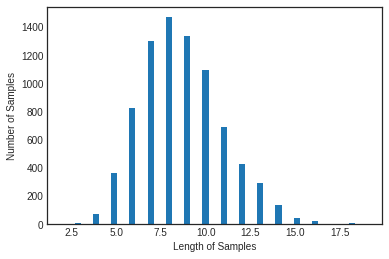

In [90]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [91]:
max_len = 20

In [92]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [93]:
np.unique(y_train)

array([0, 1])

In [106]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [109]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         388200    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 505,577
Trainable params: 505,577
Non-trainable params: 0
_________________________________________________________________


In [110]:
history = model.fit(X_train, y_train, epochs=15, batch_size=60, validation_split=0.3)

Epoch 1/15
95/95 [==============================] - 7s 52ms/step - loss: 0.2520 - acc: 0.8962 - val_loss: 0.0494 - val_acc: 0.9852
Epoch 2/15
95/95 [==============================] - 4s 47ms/step - loss: 0.0465 - acc: 0.9848 - val_loss: 0.0332 - val_acc: 0.9881
Epoch 3/15
95/95 [==============================] - 5s 47ms/step - loss: 0.0296 - acc: 0.9915 - val_loss: 0.0401 - val_acc: 0.9872
Epoch 4/15
95/95 [==============================] - 4s 47ms/step - loss: 0.0255 - acc: 0.9936 - val_loss: 0.0350 - val_acc: 0.9872
Epoch 5/15
95/95 [==============================] - 5s 48ms/step - loss: 0.0210 - acc: 0.9949 - val_loss: 0.0506 - val_acc: 0.9852
Epoch 6/15
95/95 [==============================] - 4s 47ms/step - loss: 0.0154 - acc: 0.9958 - val_loss: 0.0441 - val_acc: 0.9856
Epoch 7/15
95/95 [==============================] - 4s 47ms/step - loss: 0.0141 - acc: 0.9959 - val_loss: 0.0530 - val_acc: 0.9844
Epoch 8/15
95/95 [==============================] - 4s 47ms/step - loss: 0.0107 - a

In [111]:
model.evaluate(X_test, y_test)

85/85 [==============================] - 1s 6ms/step - loss: 0.1639 - acc: 0.9763


[0.16392582654953003, 0.9762874841690063]

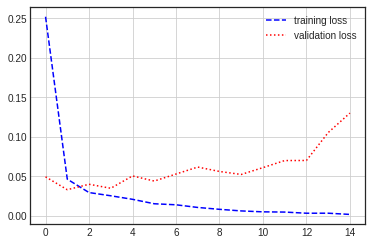

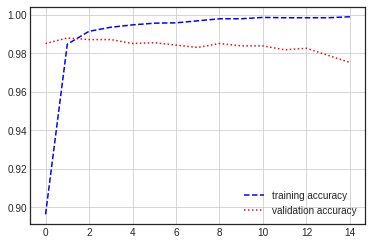

In [112]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label='training loss')
plt.plot(val_loss, 'r:', label='validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label='training accuracy')
plt.plot(val_acc, 'r:', label='validation accuracy')
plt.legend()
plt.grid()

plt.show()

In [ ]:
  # mecab = Mecab()
  # new_token = [word for word in mecab.morphs("북한 한미연합훈련 맹비난에 경협주 하락(종합)") if not word in stopwords]
  # new_sequences = tokenizer.texts_to_sequences([new_token])
  # new_pad = pad_sequences(new_sequences, maxlen=max_len)
  # score = model.predict(new_pad)

In [ ]:
# score

In [115]:
def sentiment_predict(new_sentence):
  new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
  new_sequences = tokenizer.texts_to_sequences([new_token])
  new_pad = pad_sequences(new_sequences, maxlen=max_len)
  score = float(model.predict(new_pad))

  if score > 0.5:
    print('{} -> 긍정({:.2f}%)'.format(new_sentence, score*100))
  else:
    print('{} -> 부정({:.2f}%)'.format(new_sentence, (1-score)*100))

In [116]:
sentiment_predict('정말 재미있고 흥미진진했어요.')
sentiment_predict('어떻게 이렇게 지루하고 재미없죠?')
sentiment_predict('배우 연기력이 대박입니다.')
sentiment_predict('분위기가 어둡고 스토리가 복잡해요.')

정말 재미있고 흥미진진했어요. -> 부정(98.45%)
어떻게 이렇게 지루하고 재미없죠? -> 긍정(77.05%)
배우 연기력이 대박입니다. -> 긍정(67.76%)
분위기가 어둡고 스토리가 복잡해요. -> 긍정(99.27%)


In [121]:
sentiment_predict('갤럭시 신작 폴더블폰 부품주 강세…증권가 호평')
sentiment_predict('한화시스템, 9% 급등…원웹 3450억 투자 이사회 합류')
sentiment_predict("나노씨엠에스 '투자 경고'에도 연일 강세")
sentiment_predict('애니젠, 신약 개발 기대감에 급등')
sentiment_predict('SKIET, MSCI 편입 소식에 급등세')
sentiment_predict('카카오뱅크, 하루 만에 반등…20일 MSCI 조기편입')
sentiment_predict("삼성전자-SK하이닉스, D램 가격 하락 우려에 1~2%하락 출발")
sentiment_predict('강원랜드, 실적 회복 지속 전망에 4%↑')
sentiment_predict('러시아 백신 관련주 이트론 강세')
sentiment_predict('크래프톤, 공모가 보다 낮은 시초가 형성 후 오락가락')
sentiment_predict("네오위즈 상한가‥신작 게임 동시접속자 7만 돌파")
sentiment_predict('PI첨단소재, 코스피 이전 첫날 강세')
sentiment_predict('한컴라이프케어, 코스피 입성 첫날 오전 약세')
sentiment_predict("SK하이닉스, 장중 10만원 붕괴…코스피 시총 2위 '위태'")
sentiment_predict('크래프톤, 공모가 보다 낮은 시초가 형성 후 오락가락')
sentiment_predict("삼성전자-SK하이닉스, D램 가격 하락 우려에 1~2%하락 출발")
sentiment_predict('팍스넷, 정리매매 절차 돌입에 62.8%↓')
sentiment_predict('카카오뱅크, 셋째날 하락 반전…5%대↓')
sentiment_predict('삼성중공업, 무상감자 후 거래재개…3%대 약세')

갤럭시 신작 폴더블폰 부품주 강세…증권가 호평 -> 긍정(100.00%)
한화시스템, 9% 급등…원웹 3450억 투자 이사회 합류 -> 긍정(100.00%)
나노씨엠에스 '투자 경고'에도 연일 강세 -> 긍정(100.00%)
애니젠, 신약 개발 기대감에 급등 -> 긍정(100.00%)
SKIET, MSCI 편입 소식에 급등세 -> 긍정(100.00%)
카카오뱅크, 하루 만에 반등…20일 MSCI 조기편입 -> 긍정(98.68%)
삼성전자-SK하이닉스, D램 가격 하락 우려에 1~2%하락 출발 -> 부정(100.00%)
강원랜드, 실적 회복 지속 전망에 4%↑ -> 긍정(99.99%)
러시아 백신 관련주 이트론 강세 -> 긍정(100.00%)
크래프톤, 공모가 보다 낮은 시초가 형성 후 오락가락 -> 긍정(97.27%)
네오위즈 상한가‥신작 게임 동시접속자 7만 돌파 -> 긍정(100.00%)
PI첨단소재, 코스피 이전 첫날 강세 -> 긍정(100.00%)
한컴라이프케어, 코스피 입성 첫날 오전 약세 -> 부정(100.00%)
SK하이닉스, 장중 10만원 붕괴…코스피 시총 2위 '위태' -> 부정(100.00%)
크래프톤, 공모가 보다 낮은 시초가 형성 후 오락가락 -> 긍정(97.27%)
삼성전자-SK하이닉스, D램 가격 하락 우려에 1~2%하락 출발 -> 부정(100.00%)
팍스넷, 정리매매 절차 돌입에 62.8%↓ -> 부정(99.69%)
카카오뱅크, 셋째날 하락 반전…5%대↓ -> 부정(100.00%)
삼성중공업, 무상감자 후 거래재개…3%대 약세 -> 부정(100.00%)
